# The Clairvoyant Constructor

Data Challenge: July 22, 2020\
Candidate: Isaac Chung\
Time alloted: 4 hours\
Task: Our manager is most interested in forecasting the price of each commodity up to six months into the future. In particular, your manager feels it would be really useful to understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase.

In [24]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from scipy.stats import norm, skew
from scipy import stats #qqplot

## 0. Import data
First let's import the data set, and see what's inside. Data is given in a csv file. Let's use pandas' read_csv function. I took a sneak peek and knew to parse the first column as dates.

In [25]:
data = pd.read_csv('construction_material_prices_2008_2018.csv', parse_dates=['Unnamed: 0'])

At first glance, the data has an immense amount of NaN values. The exact numbers per column will be determined shortly.

In [26]:
data.head(200)

,Unnamed: 0,price_steel,price_rebar,price_glass,price_concrete,price_plywood
0,2007-01-01,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,NaN,NaN,NaN,NaN,NaN
2,2007-01-04,NaN,NaN,NaN,NaN,NaN
3,2007-01-05,NaN,NaN,NaN,NaN,NaN
4,2007-01-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
195,2007-10-05,8.833333,NaN,23.0,23.142857,15.50
196,2007-10-08,NaN,NaN,NaN,NaN,NaN
197,2007-10-09,11.062500,NaN,23.0,29.800000,16.75
198,2007-10-10,10.833333,NaN,23.0,25.923077,16.75


## 1. Initial Data Analysis:
1. Data set shape, types
2. NaN values
3. Duplicates

In [27]:
data = data.rename(columns={"Unnamed: 0": "date"})

### 1.1 Data set shape and types
Let's see what the shape and type of the data we have. We are working with just under 3,000 rows of data, and all of the prices are continuous variables. 

In [28]:
print(data.shape)
print(data.info())

(2945, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2945 non-null   datetime64[ns]
 1   price_steel     2309 non-null   float64       
 2   price_rebar     1649 non-null   float64       
 3   price_glass     1472 non-null   float64       
 4   price_concrete  1447 non-null   float64       
 5   price_plywood   2673 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 138.2 KB
None


### 1.2 Check for NaN values
It seems like there are a lot missing values. As the portions are non-trivial (9%-51%), we should look into imputing the missing data.

In [29]:
data.isna().sum()/len(data)*100

date               0.000000
price_steel       21.595925
price_rebar       44.006791
price_glass       50.016978
price_concrete    50.865874
price_plywood      9.235993
dtype: float64

Just as a sanity check, deleting cases with missing values would alter the distribution of the data for a given features. The original distributions are shown in the blue shade, the case deletion distributions are shown in red. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D790F4908>,
      dtype=object)

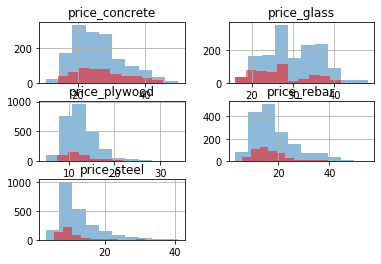

In [30]:
ax = data.hist(alpha=0.5)
data_drop = data.dropna()
data_drop.hist(ax=ax.ravel()[:5],alpha=0.5,color='r')

Choosing an imputation method helps formalizing the time-series analysis. At this point of the data challenge, I am speculating that my time will be split on data imputation and time series analysis.

There are many ways of imputating missing data. For convenience, let's look at sklearn's impute module, which provides a simple imputer, an interative imputer (MICE), and a KNN imputer.  

In [31]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10)
df_ii = imp.fit_transform(data.drop(columns=['date']))
col = ['price_steel','price_rebar','price_glass','price_concrete','price_plywood']
df_ii = pd.DataFrame(df_ii, columns=col)

C:\test\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [32]:
df_ii.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_steel     2945 non-null   float64
 1   price_rebar     2945 non-null   float64
 2   price_glass     2945 non-null   float64
 3   price_concrete  2945 non-null   float64
 4   price_plywood   2945 non-null   float64
dtypes: float64(5)
memory usage: 115.2 KB


We use the dates as index, and plot the imputed data.

In [33]:
df_ii['date'] = data['date']

In [53]:
max(data['date'])

Timestamp('2018-06-19 00:00:00')

In [34]:
df_ii = df_ii.set_index('date')

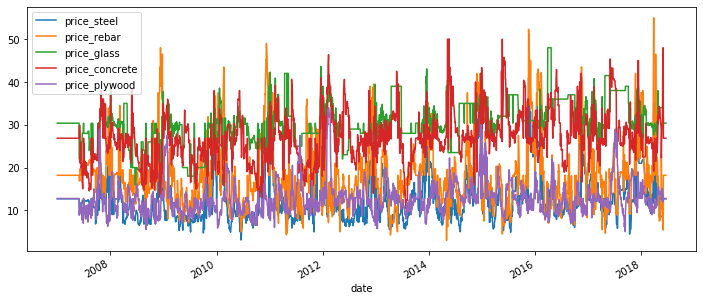

In [35]:
df_ii.plot(figsize=(12,5))
plt.show()

The imputed data looks reasonable. I also wanted to point out that having missing time-series data is a common issue data scientists face. 
Given more time, I would investigate with RNN-based imputation models, such as M-RNN and [BRITS](https://papers.nips.cc/paper/7911-brits-bidirectional-recurrent-imputation-for-time-series.pdf). 

## 2. Time Series Analysis
From a quick glance at the imputed data, we see the prices have some seasonal trends. We want a method that combines autoregression and moving averages with the ability to detect seasonality in the data. SARIMA (Seasonal Autoregressive Integrated Moving-Average) comes immediately to mind. 

SARIMA does not take into the account of exogenous variables.

In [36]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 2.1 Decomposition
We resample the data to get monthly averages of the prices. This is a reasonable step as we have the ability to hedge 6 months into the future, not just a few days or weeks. From the additive decompostion of the time series, we see a general trend, seasonality, and some residual.

Let's start with the steel prices, then move forward with the rest of the materials. Note that '...resample('M')...' would have datetime elements of the end of the month. We see that steel prices have quite clear peaks twice every year. 

In [37]:
df_resampled = df_ii.resample('M').mean()

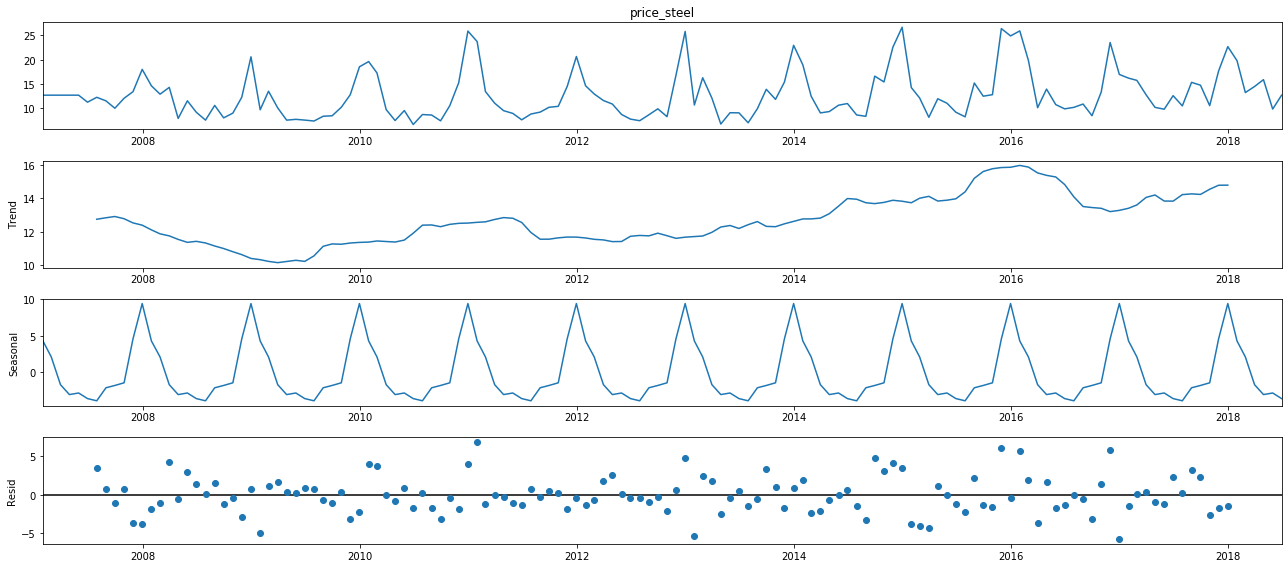

In [38]:
rcParams['figure.figsize'] = 18, 8
decomp = sm.tsa.seasonal_decompose(df_resampled['price_steel'], model='additive').plot()

### 2.2 Gridsearch for SARIMA model
Below is a manual gridsearch over the parameters for seasonal arima. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. AIC measures how well a model fits the data while taking into account the overall complexity of the model. Large AIC: Model fits very well using a lot of features. Small AIC: Model fits similar fit but using lesser features. Hence the lower the AIC, the better it is.

Given more time, I would use an available package such as sklearn to leverage parallel computing features to perform gridsearch. This would require me to write a custom estimator class to be passed in. 

In [39]:
from time import time

def manual_gs(series, pdq, seasonal_pdq):
    '''
    Takes in the time series data, 
    '''
    best = {'params':[[0,0,0],[0,0,0,12]],
            'aic':np.inf,
            'results': None}
    
    print('Running GS with %d pdq and %d seasonal pdq variants.' %(len(pdq),len(seasonal_pdq)))
    
    start = time()
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series, order=param, seasonal_order=param_seasonal, 
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                results = mod.fit()
                
                # Lower aic is better
                if results.aic < best['aic']:
                    best['aic'] = results.aic
                    best['params'][0] = param
                    best['params'][1] = param_seasonal
                    best['results'] = results
            except:
                continue
    end = time()
    print('Gridsearch terminated in %.1f seconds.' % (end-start))
    return best
        

We produce all the parameters that needed to be gridsearched over.

In [40]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [41]:
best = manual_gs(df_resampled['price_steel'], pdq, seasonal_pdq)

Running GS with 8 pdq and 8 seasonal pdq variants.
Gridsearch terminated in 11.9 seconds.


The parameters that returned the lower AIC is (p,d,q) order of (1,1,1), which means an AR(1), difference(1), MA(1) model, and (P,D,Q,s) order of (1,1,1,12). 12 here refers to monthly data. \
A P=1 would make use of the first seasonally offset observation in the model, e.g. t-(m*1) or t-12. A P=2, would use the last two seasonally offset observations t-(m * 1), t-(m * 2).

In [42]:
best

{'params': [(1, 1, 1), (1, 1, 1, 12)],
 'aic': 569.6836793348892,
 'results': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x20d7dd0e550>}

In [43]:
results = best['results']
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1852      0.115      1.608      0.108      -0.040       0.411
ma.L1         -1.0000    122.221     -0.008      0.993    -240.548     238.548
ar.S.L12       0.0023      0.005      0.497      0.619      -0.007       0.011
ma.S.L12      -0.7740      0.081     -9.601      0.000      -0.932      -0.616
sigma2         8.1789    999.882      0.008      0.993   -1951.553    1967.911


### 2.3 Model Diagnostics
What should we expect from the diagnostics?

The residuals should be normally distributed. Top right: the orange KDE line should closely match the green N(0,1) (normal distribution with zero mean and unit variance) line. Bottom left: the qq plot shows the ordered distribution of residuals which follows the linear trend of samples taken from N(0,1).

The residuals are not correlated. Top left: the standardized residuals do not display seasonality and appear to be noise. Bottom right: the autocorrelation (correlogram) plot shows that the time series residuals have low correlation with irs own lagged versions.

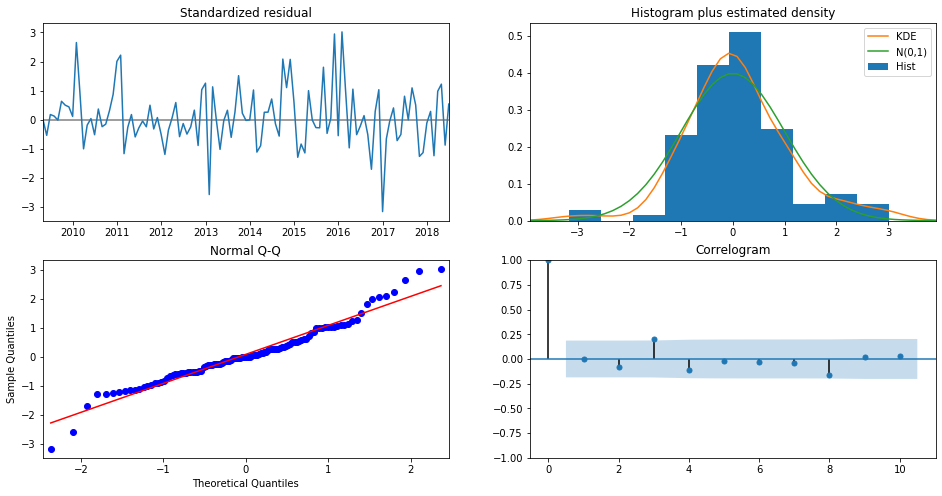

In [44]:
diag = results.plot_diagnostics(figsize=(16,8))

### 2.4 Model Validation
We can use a subset of the data to validate our time series model. Here we can choose the data starting from 2014. Here we see the prediction seems to fit well with the observed data. The confidence interval defaults to 95%.

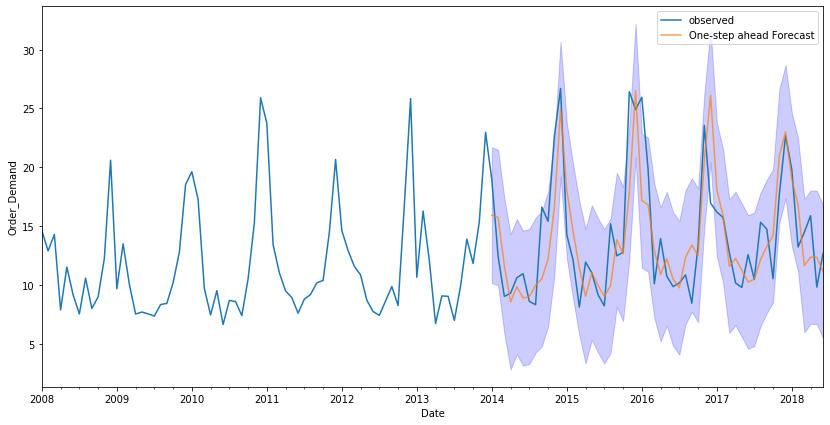

In [45]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-31'), dynamic=False) #false is when using the entire history.
pred_ci = pred.conf_int()

ax = df_resampled['price_steel']['2008':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

### 2.5 Forecasting
Now we would like to forecast order demands for the next 6 months. As expected, the further ahead in time, the more variance is expected from the prediction. Here the predictions for the next 24 months are shown, and the first 6 months emphasized between the two vertical lines.

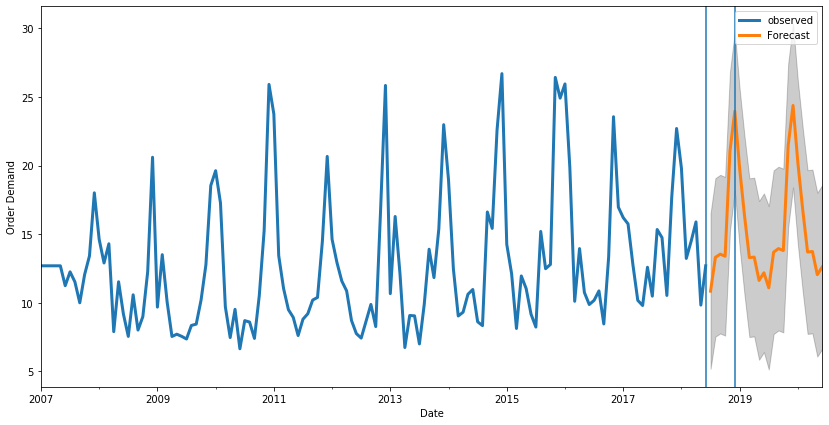

In [54]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = df_resampled['price_steel'].plot(label='observed', figsize=(14, 7), linewidth=3)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', linewidth=3)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order Demand')
plt.legend()
plt.axvline(x=pd.to_datetime('2018-06-30'))
plt.axvline(x=pd.to_datetime('2018-12-31'))

The predict price for steel follows an upward trend for the next 6 months. **We should buy steel early.**

## 3. Apply to other commodities
We can then repeat most of these steps for the rest of the commodities. First I define some helpful functions to declutter this space. 

In [73]:
def get_results_diag(col_name):
    # run gridsearch for the SARIMA model
    best = manual_gs(df_resampled[col_name], pdq, seasonal_pdq)
    results = best['results']
    diag = results.plot_diagnostics(figsize=(16,8))
    return results

In [78]:
def validate(col_name, results):
    # Validation
    pred = results.get_prediction(start=pd.to_datetime('2014-01-31'), dynamic=False) #false is when using the entire history.
    pred_ci = pred.conf_int()

    ax = df_resampled[col_name]['2008':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='blue', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Order_Demand')
    plt.legend()

In [80]:
def forecast(col_name, results):
    # Forecasting
    pred_uc = results.get_forecast(steps=24)
    pred_ci = pred_uc.conf_int()
    ax = df_resampled[col_name].plot(label='observed', figsize=(14, 7), linewidth=3)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast', linewidth=3)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Order Demand')
    plt.legend()
    plt.axvline(x=pd.to_datetime('2018-06-30'))
    plt.axvline(x=pd.to_datetime('2018-12-31'))

## 3.1 Rebar
From the diagnostics we see that the distribution is a bit skewed, which is also reflected in the Q-Q plot. Model validation shows that the SARIMA model is visually close to the observed prices. Predictions show that rebar prices are on an upwards trend, and we should buy rebar early. 

Running GS with 8 pdq and 8 seasonal pdq variants.
Gridsearch terminated in 10.8 seconds.


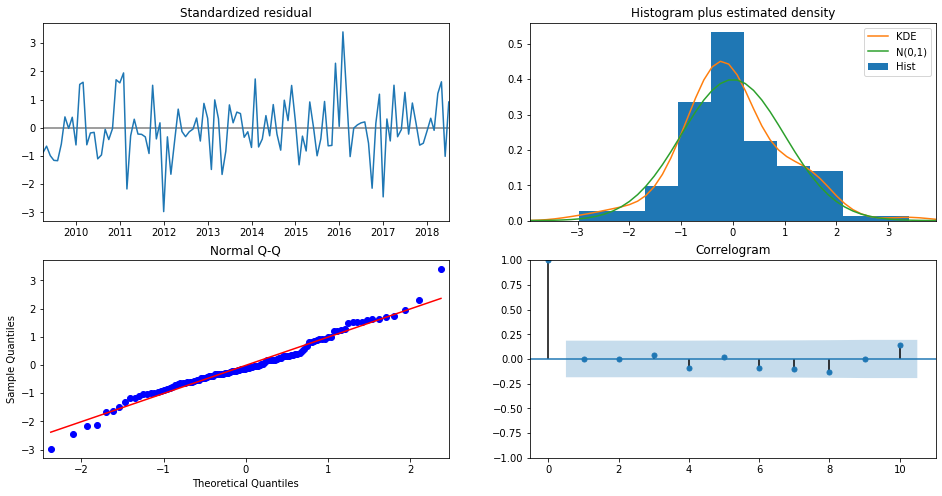

In [76]:
results_r = get_results_diag('price_rebar')

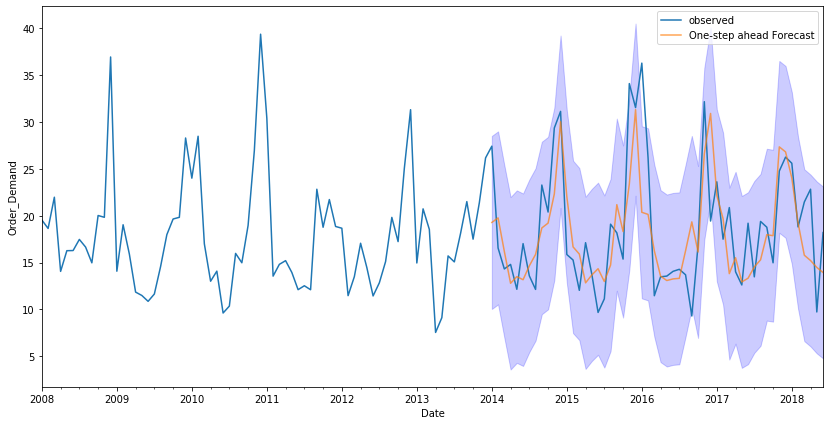

In [79]:
validate('price_rebar', results_r)

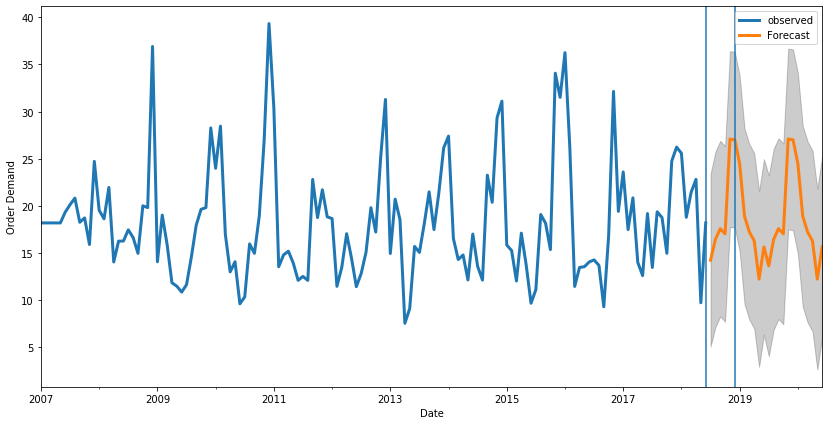

In [81]:
forecast('price_rebar', results_r)

## 3.2 Glass
From the diagnostics we see that the distribution is a bit skewed, which is also reflected in the Q-Q plot. Model validation shows that the SARIMA model is visually close to the observed prices. Predictions show that glass prices are on an upwards trend, and we should buy glass early. 

Running GS with 8 pdq and 8 seasonal pdq variants.
Gridsearch terminated in 9.2 seconds.


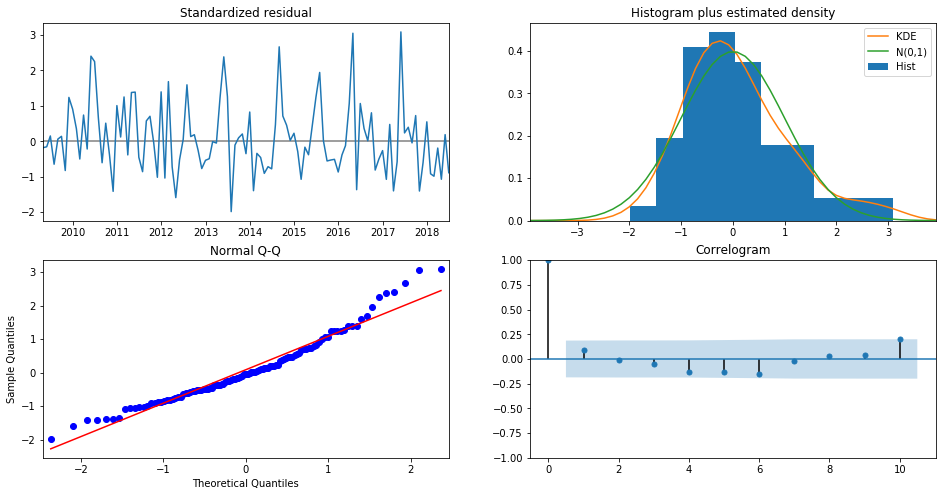

In [82]:
results_g = get_results_diag('price_glass')

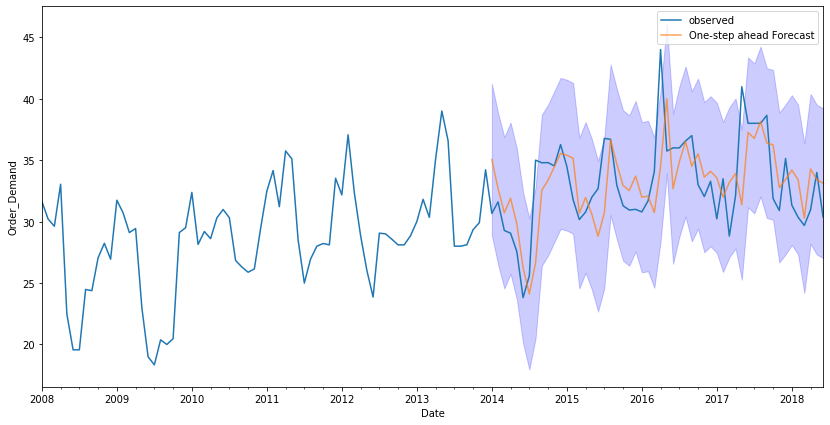

In [83]:
validate('price_glass', results_g)

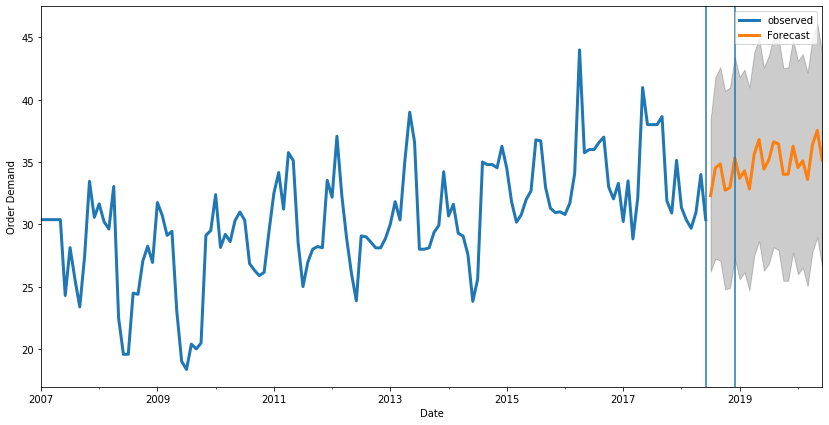

In [84]:
forecast('price_glass', results_g)

## 3.3 Concrete
From the diagnostics we see that the distribution is a bit skewed, which is also reflected in the Q-Q plot. Model validation shows that the SARIMA model is visually close to the observed prices. Predictions show that concrete prices are on an upwards trend, and we should buy concrete early. 

Running GS with 8 pdq and 8 seasonal pdq variants.
Gridsearch terminated in 11.0 seconds.


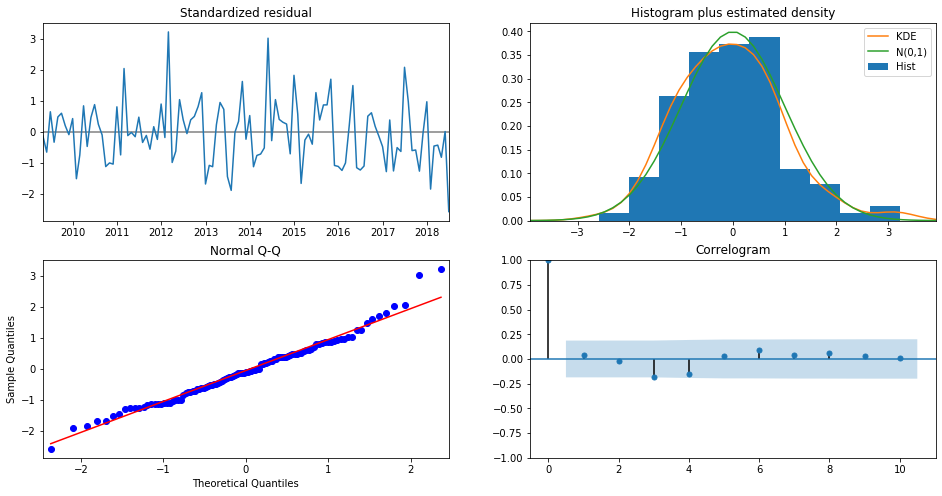

In [85]:
results_c = get_results_diag('price_concrete')

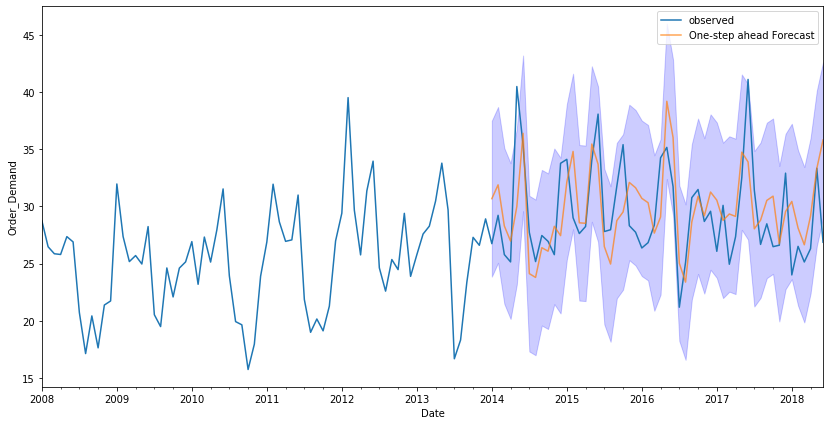

In [86]:
validate('price_concrete', results_c)

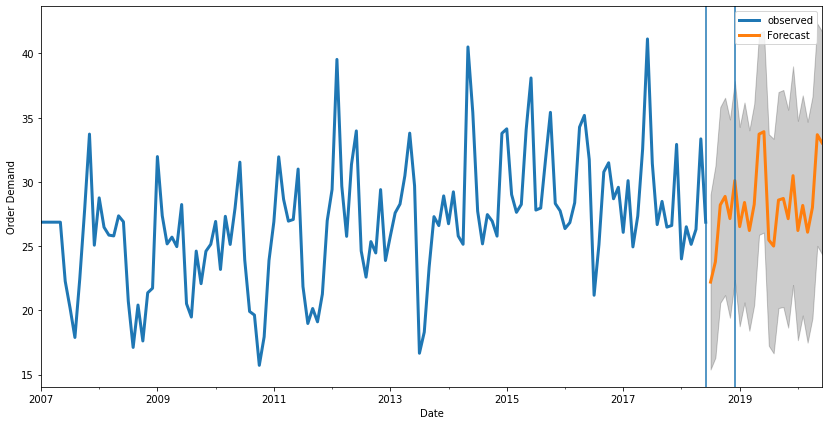

In [87]:
forecast('price_concrete', results_c)

## 3.4 Plywood
From the diagnostics we see that the distribution is a bit skewed, which is also reflected in the Q-Q plot. Model validation shows that the SARIMA model is visually close to the observed prices. Predictions show that plywood prices are fluctuating within the 6 month period. We should wait for the temporary increase to pass to purchase plywood.

Running GS with 8 pdq and 8 seasonal pdq variants.


C:\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Gridsearch terminated in 11.8 seconds.


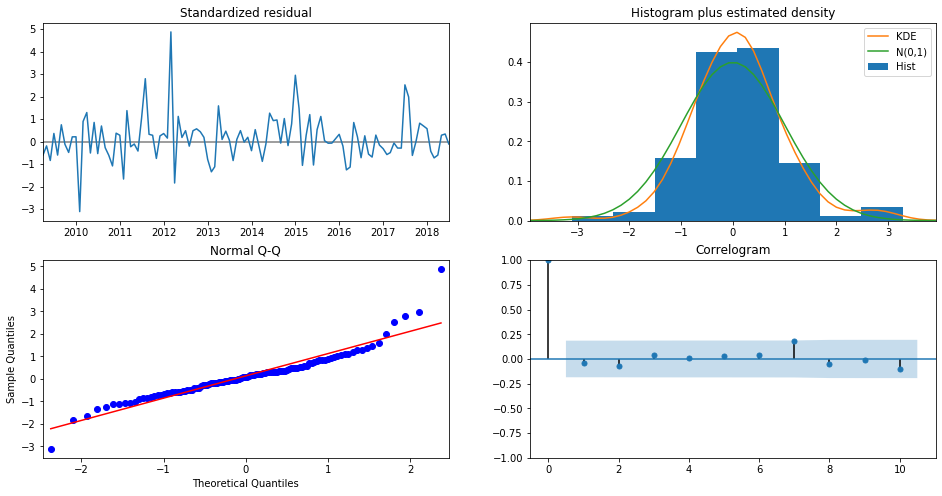

In [88]:
results_p = get_results_diag('price_plywood')

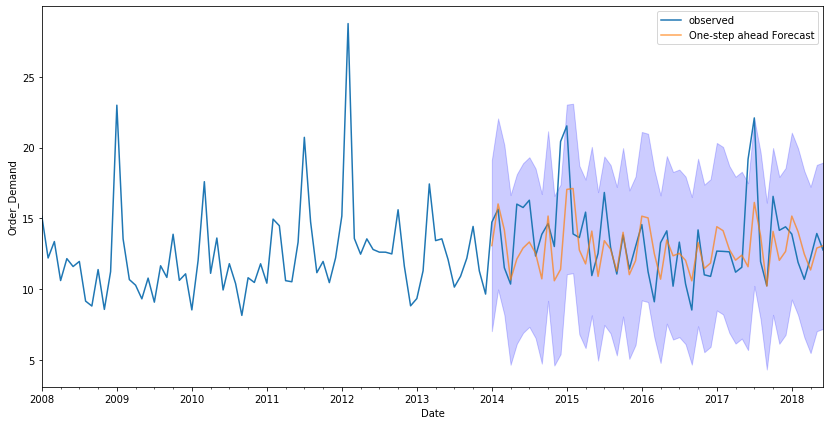

In [89]:
validate('price_plywood', results_p)

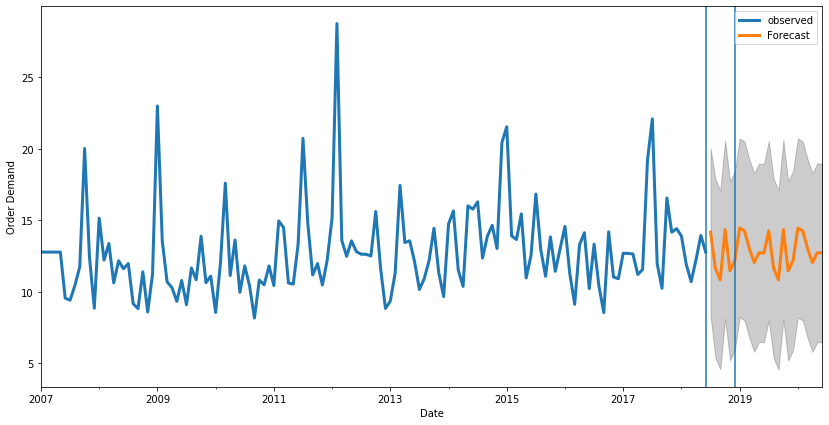

In [90]:
forecast('price_plywood', results_p)

## 4. Conclusion
We analyzed the historic prices of steel, rebar, glass, concrete, and plywood, and were able to use a SARIMA model to predict the prices for these commodities in the next few months. From these results, we can make an informed decision on whether to purchase these commodities early or wait till after a temporary increase.

*For all commodities except for plywood, we should purchase now. For plywood, we can wait for the temporary increase to subside.*

Given more time, I would look into building a more efficient pipeline with gridsearch, and perhaps look into more complicated models such as SARIMAX to incorporate exogenous variables, or deep learning models such as RNN and LSTM. 